<h1><u>Advancedn topics in ML - Assignment III - task A</u></h1>
<h4>Omer Nivron</h4>
15098443

In [ ]:
    #line4,=plt.plot(x1, y1_av,"b",label='moving average')

In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # side-stepping mpl backend
import os

In [12]:
def plot_eps_len(List,epochs,title,lr_d):
    line={}
    colors=['b','k','g','c','y','r']
    x1=range(epochs)
    for i in range(np.shape(List)[1]):
        y = List[:,i]
        line[i]=plt.plot(x1,y,colors[i],label=lr_d[i])
    plt.xlabel('Epoch')
    plt.ylabel('Eps length')
    plt.title(title)
    plt.legend(loc=3,prop={'size':9})    

In [13]:
def plot_loss(List,epochs,title,lr_d):
    line={}
    colors=['b','k','g','c','y','r']
    x1=range(epochs)
    for i in range(np.shape(List)[1]):
        y = List[:,i]
        plt.subplot(2, 2, i+1)
        line[i]=plt.plot(x1,y,colors[i],label=lr_d[i])
        plt.xlabel('Epoch')
        plt.ylabel('Bellman loss')
        plt.title(title)
        plt.legend(loc=3,prop={'size':7})
    plt.tight_layout()
    plt.show()

In [ ]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [ ]:
#observation=[position of cart, velocity of cart, angle of pole, rotation rate of pole]

<h1>part A</h1>

In [ ]:
env = gym.make('CartPole-v0')

In [ ]:
#create lists to contain total rewards
rList = []
lr = 1
y = .99
num_episodes = 3
size=(3,2)
return_matrix=np.zeros(size)

In [ ]:
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        print(s)
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 300:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.sum(np.random.uniform(0,1)>0.5)
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            r=0
            s = s1
            if d == True:
                r=-1
                rAll += r
                return_=-1*y**j
                print("Episode finished after {} timesteps".format(j+1))
                break
        rList.append(rAll)
        print 
        print "Score over time: " +  str(sum(rList)/num_episodes)
        return_matrix[i]=np.append(j+1,return_)

In [ ]:
pd.DataFrame(return_matrix)

<h1>part B</h1>

In [ ]:
#create lists to contain total rewards
rList = []
lr = 1
y = .99
num_episodes = 100
size=(100,2)
return_matrix=np.zeros(size)

In [ ]:
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        print(s)
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 300:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.sum(np.random.uniform(0,1)>0.5)
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            r=0
            s = s1
            if d == True:
                r=-1
                rAll += r
                return_=-1*y**j
                print("Episode finished after {} timesteps".format(j+1))
                break
        rList.append(rAll)
        print 
        print "Score over time: " +  str(sum(rList)/num_episodes)
        return_matrix[i]=np.append(j+1,return_)

In [ ]:
(np.mean(return_matrix,0))

In [ ]:
np.std(return_matrix,0)

<h1>part C linear layer</h1>

In [ ]:
import gym
import numpy as np
import random
import tensorflow as tf
import itertools
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
import matplotlib
from __future__ import division
matplotlib.style.use('ggplot')

In [ ]:
env = gym.make('CartPole-v0')

In [ ]:
env._max_episode_steps = 300

In [ ]:
epochs=100
lr_d=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
batch_s=100
y=.99
n_eps=2000
num_eps_test=100

In [ ]:
def plh():
    with tf.name_scope('states'):
        states=tf.placeholder("float32",[None,4],name='states')
    with tf.name_scope('s_ne'):
        s_ne=tf.placeholder("float32",[None,4],name='s_ne')
    with tf.name_scope('targetQ'):
        targetQ=tf.placeholder("float32",[None,2],name='targetQ')
    return(states,s_ne,targetQ)

In [ ]:
def graph(lr,states,s_ne,targetQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [2],initializer=tf.constant_initializer(0,0.001))
    Q = (tf.matmul(states,W1)+ b1)
    Q_prime =(tf.matmul(s_ne,W1)+ b1)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1) )  
    with tf.name_scope('loss'):
        loss=tf.reduce_mean(tf.square((targetQ) -(Q)))
    with tf.name_scope('train'):   
        trainer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

In [ ]:
def test_epoch(sess,epoch):
    eps_len=[]
    avg_eps_len=[]
    for eps in range(num_eps_test):
        s=env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            test_Q=sess.run(Q_prime,feed_dict={s_ne:s})
            act=np.argmax(test_Q)
            s1,r,d,_ = env.step(act)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j+1)
                break       
    avg_eps_len.append(np.mean(eps_len))
    return (avg_eps_len)

In [ ]:
def collect_offline_observ(num_episodes):
    store=[]
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        d = False
        j = 0     
        while j < 300:
            a = np.sum(np.random.uniform(0,1)>0.5)
            s1,r,d,_ = env.step(a)
            r=0
            if (d==True):
                r=-1
                #print("Episode finished after {} timesteps".format(j))            
            tmp_st=np.append(a,s)
            tmp_st=np.append(tmp_st,s1)
            tmp_st=np.append(tmp_st,r)
            store=np.append(store,tmp_st)
            if (d==True):
                break
            j+=1
            s=s1
    store=np.reshape(store,[-1,10])
    return(store)

In [ ]:
observations=collect_offline_observ(n_eps)

In [ ]:
#create lists to contain total rewards and steps per episode
size=(100,6)
all_loss=np.zeros(size)
all_len=np.zeros(size)
st=0
for lr in lr_d:
    tf.reset_default_graph()
    states,s_ne,targetQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    lo_List = []
    eps_len=[]
    obser_len=np.shape(observations)[0]
    num_batch=int(obser_len/batch_s)
    #avg_eps_len=np.zeros(epochs)
    for epoch in range(epochs):

        eps_len.append(test_epoch(sess,epoch))

        for batch_num in range(num_batch):

            batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batch_s)

            batch_cur_st=np.reshape(observations[[batch_rows],1:5],[batch_s,4])

            batch_nex_st=np.reshape(observations[[batch_rows],5:9],[batch_s,4])

            actions=np.reshape(observations[[batch_rows],0],[100,1])

            rewards=np.reshape(observations[[batch_rows+1],-1],[100,1])
            delta=rewards+1
            #delta=1
            # I get for allQ a [1,2] vector 
            current_Q,max_Q1=sess.run([Q,maxQ1],feed_dict={states:batch_cur_st,s_ne:batch_nex_st})
            target_Q=np.copy(current_Q)
            max_Q1=np.reshape(max_Q1,[100,1])     
            row_idx = np.array(range(batch_s))
            target_Q[row_idx[:,None],[actions]]=delta*y*max_Q1+rewards 
            _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,s_ne:batch_nex_st,targetQ:target_Q})
        lo_List.append(lo)
        folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_c/linear/'+str(lr)
        save_path=saver.save(sess,folder+'/accu')
    all_loss[:,st]=lo_List
    all_len[:,st]=eps_len
    st+=1

In [ ]:
plot_eps_len(all_len,epochs,'a',lr_d)
plt.show()

In [ ]:
plot_loss(all_loss,epochs,'a',lr_d)
plt.show()

<h1>part C NN</h1>

In [19]:
import os
import gym
import numpy as np
import random
import tensorflow as tf
import itertools
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
import matplotlib
from __future__ import division
matplotlib.style.use('ggplot')

In [2]:
env = gym.make('CartPole-v0')

[2017-04-10 21:22:36,180] Making new env: CartPole-v0


In [3]:
env._max_episode_steps = 300

<h2>Configurations</h2>

In [4]:
epochs=100
lr_d=[0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
batch_s=100
y=.99
n_eps=2000
num_eps_test=100

<h3>Var creation</h3>
We build data placeholders 

In [5]:
def plh():
    with tf.name_scope('states'):
        states=tf.placeholder("float32",[None,4],name='states')
    with tf.name_scope('s_ne'):
        s_ne=tf.placeholder("float32",[None,4],name='s_ne')
    with tf.name_scope('targetQ'):
        targetQ=tf.placeholder("float32",[None,2],name='targetQ')
    return(states,s_ne,targetQ)

<h3>Define model</h3>

In [6]:
def graph(lr,states,s_ne,targetQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
        W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    h2 = tf.nn.relu(tf.matmul(s_ne,W1)+ b1)
    Q=tf.matmul(h1,W2)+b2
    Q_prime=tf.matmul(h2,W2)+b2
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1) )  
    with tf.name_scope('loss'):
        loss=tf.reduce_mean(tf.square((targetQ) -(Q)))
    with tf.name_scope('train'):   
        trainer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

<h3>Define loss & optimizer</h3>

In [7]:
 def test_epoch(sess):
    eps_len=[]
    avg_eps_len=[]
    for eps in range(num_eps_test):
        s=env.reset()
        s=np.reshape(s,[1,4])
        j=0
        while j < 300:
            j+=1
            test_Q=sess.run(Q_prime,feed_dict={s_ne:s})
            act=np.argmax(test_Q)
            s1,r,d,_ = env.step(act)
            s1=np.reshape(s1,[1,4])
            s=s1
            if (d==True):
                eps_len.append(j+1)
                break       
    avg_eps_len.append(np.mean(eps_len))
    return (avg_eps_len)

In [8]:
def collect_offline_observ(num_episodes):
    store=[]
    for i in range(num_episodes):
    #Reset environment and get first new observation
        s = env.reset()
        d = False
        j = 0     
        while j < 300:
            a = np.sum(np.random.uniform(0,1)>0.5)
            s1,r,d,_ = env.step(a)
            r=0
            if (d==True):
                r=-1
                #print("Episode finished after {} timesteps".format(j))            
            tmp_st=np.append(a,s)
            tmp_st=np.append(tmp_st,s1)
            tmp_st=np.append(tmp_st,r)
            store=np.append(store,tmp_st)
            if (d==True):
                break
            j+=1
            s=s1
    store=np.reshape(store,[-1,10])
    return(store)

In [9]:
observations=collect_offline_observ(n_eps)

In [10]:
#create lists to contain total rewards and steps per episode
size=(100,6)
all_loss=np.zeros(size)
all_len=np.zeros(size)
st=0
for lr in lr_d:
    tf.reset_default_graph()
    states,s_ne,targetQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    lo_List = []
    eps_len=[]
    obser_len=np.shape(observations)[0]
    num_batch=int(obser_len/batch_s)
    #avg_eps_len=np.zeros(epochs)
    for epoch in range(epochs):

        eps_len.append(test_epoch(sess))

        for batch_num in range(num_batch):

            batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batch_s)

            batch_cur_st=np.reshape(observations[[batch_rows],1:5],[batch_s,4])

            batch_nex_st=np.reshape(observations[[batch_rows],5:9],[batch_s,4])

            actions=np.reshape(observations[[batch_rows],0],[100,1])

            rewards=np.reshape(observations[[batch_rows+1],-1],[100,1])
            delta=rewards+1
            #delta=1
            # I get for allQ a [1,2] vector 
            current_Q,max_Q1=sess.run([Q,maxQ1],feed_dict={states:batch_cur_st,s_ne:batch_nex_st})
            target_Q=np.copy(current_Q)
            max_Q1=np.reshape(max_Q1,[100,1])     
            row_idx = np.array(range(batch_s))
            target_Q[row_idx[:,None],[actions]]=delta*y*max_Q1+rewards 
            _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,targetQ:target_Q})
        lo_List.append(lo)
        folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_c/'+str(lr)
        save_path=saver.save(sess,folder+'/accu')
    all_loss[:,st]=lo_List
    all_len[:,st]=np.reshape(np.asarray(eps_len),[100])
    st+=1

/Users/onivron/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


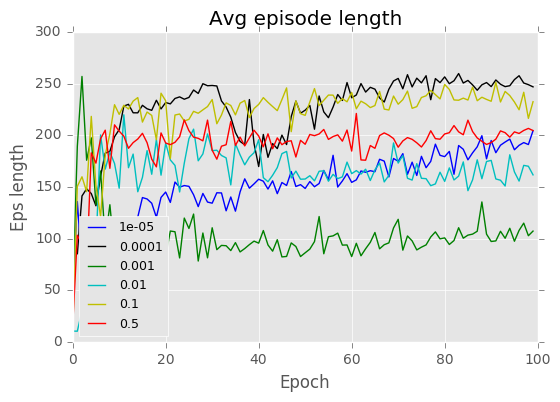

In [14]:
plot_eps_len(all_len,epochs,'Avg episode length',lr_d)
plt.show()

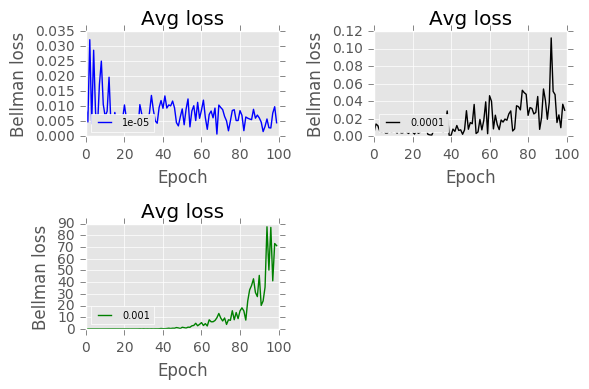

In [15]:
plot_loss(all_loss[:,0:3],epochs,'Avg loss',lr_d)
plt.show()

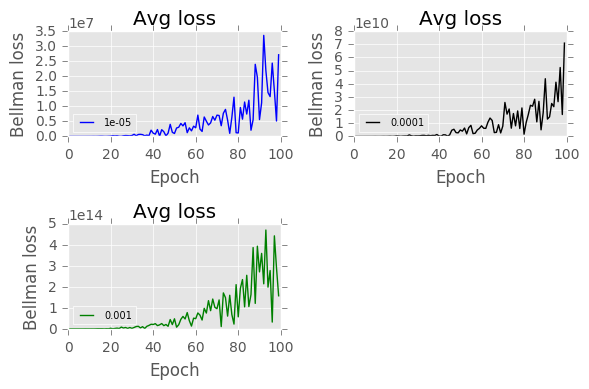

In [16]:
plot_loss(all_loss[:,3:6],epochs,'Avg loss',lr_d)
plt.show()

<h1> testing w/ saved weights </h1>

In [21]:
tf.reset_default_graph()
for lr in lr_d:
    save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_c/'+str(lr)+'/'
    save_model = os.path.join(save_MDir,'accu')
    states,s_ne,targetQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
    # restore model and calculate mean length and return over n_test episodes
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess = sess, save_path= save_model)
        print("Model for learning rate: ",lr)
        leng = test_epoch(sess)
        print('Mean episode length:',leng)
    tf.reset_default_graph()

('Model for learning rate: ', 1e-05)
('Mean episode length:', [190.72])
('Model for learning rate: ', 0.0001)
('Mean episode length:', [255.27000000000001])
('Model for learning rate: ', 0.001)
('Mean episode length:', [110.81])
('Model for learning rate: ', 0.01)
('Mean episode length:', [160.72999999999999])
('Model for learning rate: ', 0.1)
('Mean episode length:', [240.81999999999999])
('Model for learning rate: ', 0.5)
('Mean episode length:', [197.02000000000001])


In [17]:
sess.close()

<h1>part D</h1>

In [ ]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
env = gym.make('CartPole-v0')

In [ ]:
env._max_episode_steps = 300

In [ ]:
# Set learning parameters
lr=0.001
y = .99
num_episodes=2000
e=0.05

In [ ]:
def plh():
    states=tf.placeholder(shape=[1,4],dtype=tf.float32)
    nextQ = tf.placeholder(shape=[1,2],dtype=tf.float32)
    return(states,nextQ)

In [ ]:
def graph(lr,states,nextQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
        W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime=(tf.matmul(h2,W2)+b2)
    maxQ1=tf.stop_gradient(tf.reduce_max(Q_prime,1) )  
    predict=tf.argmax(Q,1)
    loss = tf.reduce_sum(tf.square((nextQ) - Q)/2)
    trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    return Q,maxQ1,Q_prime,loss,trainer

In [ ]:
#create lists to contain total rewards and steps per episode
run_avg_loss=[]
run_avg_eps_len=[]
size=(2000,100)
jList = np.zeros(size)
lo_List = np.zeros(size)

for run in range(2):
    tf.reset_default_graph()
    states,nextQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,nextQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            maxQ1 = sess.run(maxQ1,feed_dict={states:s1})            
            targetQ=np.copy(allQ)
            if d == False:
                r=0
                targetQ[0,a]=y*(maxQ1)+r
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})
            else:
                r=-1
                targetQ[0,a]=r 
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})          
                break
            s = s1 
        folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_d/'+str(lr)
        save_path=saver.save(sess,folder+'/accu')
        lo_List[i,run]=(lo)
        jList[i,run]=(j+1)
all_loss=np.mean(lo_List,1)
all_leng=np.mean(jList,1)

In [ ]:
plot_eps_len(all_len,epochs,'Avg episode length over 100 runs, each of 2000 episodes',lr_d)
plt.show()

In [ ]:
plot_loss(all_loss[:,0],epochs,'Avg loss over 100 runs, each of 2000 episodes',lr_d)
plt.show()

<h1> testing w/ saved weights </h1>

In [ ]:
tf.reset_default_graph()
save_MDir='/Users/onivron/trained_models/ass_3/weights/task_A_part_d/'+str(lr)+'/'
save_model = os.path.join(save_MDir,'accu')
states,s_ne,targetQ=plh()
Q,Q_prime,loss,trainer=graph(lr,states,s_ne,targetQ)
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess = sess, save_path= save_model)
    eps_len=[]
    avg_eps_len=[]
# 100 testing episodes   
    for i in range(100):
        s = env.reset()
        while j < 300:
        j+=1
        allQ = sess.run(Q,feed_dict={states:s})
        a=np.argmax(allQ)
        s1,r,d,_ = env.step(a)
        s1=np.reshape(s1,[1,4])
        s=s1
        if (d==True):
            eps_len.append(j+1)
            break
    avg_eps_len.append(np.mean(eps_len))    
    print('Avg episode length:',avg_eps_len)

In [ ]:
sess.close()

<h1>part E - 30 hidden units</h1>

In [ ]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
env = gym.make('CartPole-v0')

In [ ]:
env._max_episode_steps = 300

In [ ]:
y=.99
num_episodes=2000
e=0.05

In [ ]:
def plh():
    nextQ = tf.placeholder(shape=[1,2],dtype=tf.float32)
    states=tf.placeholder(shape=[1,4],dtype=tf.float32) 

In [ ]:
def graph(states,nextQ):
    with tf.name_scope("weights"):
        W1 = tf.get_variable("W1", [4, 1000],initializer=tf.random_normal_initializer(0,0.001))
        W2= tf.get_variable("W2", [1000, 2],initializer=tf.random_normal_initializer(0,0.001))
    with tf.name_scope("biases"):
        b1 = tf.get_variable("b1", [1000],initializer=tf.constant_initializer(0,0.001))
        b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime=(tf.matmul(h2,W2)+b2)
    maxQ1=tf.stop_gradient(Q_primeprimeprime.reduce_max(Q_prime,1))  
    loss = tf.reduce_sum(tf.square((nextQ) - Q)/2)
    trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    return(Q,maxQ1,Q_prime,loss,trainer)

In [ ]:
# Network with 30 hidden units
size=(101,1)
jList_30 = np.zeros(size)
lo_List_30 = np.zeros(size)
sess=tf.Session()
sess.run(init)
for run in range(1):
    tf.reset_default_graph()
    states,nextQ=plh()
    Q,maxQ1,Q_prime,loss,trainer=graph(lr,states,s_ne,nextQ)
    saver = tf.train.Saver(write_version = tf.train.SaverDef.V2)
    sess=tf.Session() 
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q_1,feed_dict={states:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            maxQ1 = sess.run(maxQ1,feed_dict={states:s1})            
            targetQ=np.copy(allQ)
            if d == False:
                r=0
                targetQ[0,a]=y*(maxQ1)+r
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})
            else:
                r=-1
                targetQ[0,a]=r 
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss],feed_dict={states:s,nextQ:targetQ})          
                break
            s = s1
        folder='/Users/onivron/trained_models/ass_3/weights/task_A_part_e/'+str(30)
        save_path=saver.save(sess,folder+'/accu')
        if ((i+1)%20==0):
            lo_List_30[(i+1),run]=(lo)
            jList_30[(i+1),run]=(j)

plt.plot(jList_30[1:100,:])
plt.show()

<h1>part E - 1000 hidden units</h1>

In [ ]:
nextQ_2 = tf.placeholder(shape=[1,2],dtype=tf.float32)

In [ ]:
states_net_2=tf.placeholder(shape=[1,4],dtype=tf.float32) 
with tf.name_scope("weights_net_2"):
    W1_ne_2 = tf.get_variable("W1_ne_2", [4, 1000],initializer=tf.random_normal_initializer(0,0.001))
    W2_ne_2 = tf.get_variable("W2_ne_2", [1000, 2],initializer=tf.random_normal_initializer(0,0.001))
with tf.name_scope("biases_net_2"):
    b1_ne_2 = tf.get_variable("b1_ne_2", [1000],initializer=tf.constant_initializer(0,0.001))
    b2_ne_2 = tf.get_variable("b2_ne_2", [2],initializer=tf.constant_initializer(0,0.001))

In [ ]:
pred_2,Q_2,Q_prime_2=observation_to_action_net_2(states_net_2)
loss_net_2 = tf.reduce_sum(tf.square((nextQ_2) - Q_2)/2)
trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_net_2)

In [ ]:
def observation_to_action_net_2(states_net_2):
    h1 = tf.nn.relu(tf.matmul(states_net_2, W1_ne_2) + b1_ne_2)
    Q_net_2=tf.matmul(h1, W2_ne_2) + b2_ne_2
    h2 = tf.nn.relu(tf.matmul(states_net_2,W1_ne_2)+ b1_ne_2)
    Q_prime_net_2=tf.stop_gradient(tf.matmul(h2,W2_ne_2)+b2_ne_2)
    predict_net_2=tf.argmax(Q_net_2,1)
    return predict_net_2,Q_net_2,Q_prime_net_2

In [ ]:
# Network with 1000 hidden units
size=(101,1)
jList = np.zeros(size)
lo_List = np.zeros(size)
sess=tf.Session()
sess.run(init)
for run in range(1):
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q_2,feed_dict={states_net_2:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            s1=np.reshape(s1,[1,4])
            Q1 = sess.run(Q_prime_2,feed_dict={states_net_2:s1})            
            maxQ1 = np.max(Q1)
            targetQ=np.copy(allQ)
            if d == False:
                r=0
                targetQ[0,a]=y*(maxQ1)+r
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss_net_2],feed_dict={states_net_2:s,nextQ_2:targetQ})
            else:
                r=-1
                targetQ[0,a]=r 
                targetQ=np.reshape(targetQ,[1,2])
                _,lo=sess.run([trainer,loss_net_2],feed_dict={states_net_2:s,nextQ_2:targetQ})
                if (i%50==0):
                    print("Episode finished after {} timesteps with loss {}".format(j+1,lo))            
                break
            s = s1                  
        if ((i+1)%20==0):
            lo_List[((i+1)/20),run]=(lo)
            jList[((i+1)/20),run]=(j)

<h1>part F</h1>

In [ ]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
env = gym.make('CartPole-v0')

In [ ]:
tf.reset_default_graph()

In [ ]:
y = .99
num_episodes=20000
num_eps_test=100
e=0.05

In [ ]:
states=tf.placeholder(shape=[None,4],dtype=tf.float32) 
with tf.name_scope("weights"):
    W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
    W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
with tf.name_scope("biases"):
    b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
    b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))

In [ ]:
nextQ = tf.placeholder(shape=[None,2],dtype=tf.float32)

In [ ]:
def observation_to_action(states):
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime=tf.stop_gradient(tf.matmul(h2,W2)+b2)
    predict=tf.argmax(Q,1)
    return predict,Q,Q_prime

In [ ]:
#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
pred,Q,Q_prime=observation_to_action(states)
loss = tf.reduce_mean(tf.square((nextQ) - Q))
trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
#create lists to contain total rewards and steps per episode
batchSize = 32
bufferx=100
h=0
replay = []
#stores tuples of (S, A, R, S')
size=(101,1)
jList = []
lo_List = []
avg_eps_len=[]
sess=tf.Session()
sess.run(init)
for run in range(1):
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            if (d==True):
                r=-1    
            else:
                r=0
            s1=np.reshape(s1,[1,4])
            #Experience replay storage
            if (len(replay) < bufferx): #if buffer not filled, add to it
                replay.append((s, a, r, s1))
            else: #if buffer full, overwrite old values
                #randomly sample our experience replay memory
                if (h < (bufferx-1)):
                    h += 1
                else:
                    h = 0
                replay[h] = (s, a, r, s1)        
                observations=np.copy(replay)
                batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batchSize)
                batch_cur_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],0])),[batchSize,4])
                batch_nex_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],3])),[batchSize,4])
                actions=np.reshape(np.concatenate(observations[[batch_rows],1]),[batchSize,1])
                rewards=np.reshape(np.concatenate(observations[[batch_rows+1],2]),[batchSize,1])
                delta=rewards+1
                current_Q=sess.run(Q,feed_dict={states:batch_cur_st})
                target_Q=np.copy(current_Q)
                Q_s_prime=sess.run(Q_prime,feed_dict={states:batch_nex_st})
                maxQ1=np.reshape(np.max(Q_s_prime,1),[batchSize,1])
                row_idx = np.array(range(batchSize))
                target_Q[row_idx[:,None],[actions]]=delta*y*maxQ1+rewards 
                _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,nextQ:target_Q})
                lo_List.append(lo)
            if (d==True):
                break
            s=s1
        if lo:
            print("Episode {} with loss {}".format(i,lo)) 
            
        if ((i%2)==0):
            eps_len=[]
            for eps in range(num_eps_test):
                st_te=env.reset()
                st_te=np.reshape(st_te,[1,4])
                t=0
                while t < 300:
                    t+=1
                    test_Q=sess.run(Q_prime,feed_dict={states:st_te})
                    act=np.argmax(test_Q)
                    new_st_te,re,done,_ = env.step(act)
                    new_st_te=np.reshape(new_st_te,[1,4])
                    if (done==True):
                        in_eps_len=np.copy(t)
                        eps_len.append(in_eps_len)
                        break
                    else:
                        st_te=new_st_te
                if ((eps%99==0) & (eps>0)):
                    print("Episode finished after {} timesteps".format(t))  
            avg_eps_len.append(np.mean(eps_len))

<h1>part G</h1>

In [ ]:
states=tf.placeholder(shape=[None,4],dtype=tf.float32) 
with tf.name_scope("weights"):
    W1 = tf.get_variable("W1", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
    W2 = tf.get_variable("W2", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
with tf.name_scope("biases"):
    b1 = tf.get_variable("b1", [100],initializer=tf.constant_initializer(0,0.001))
    b2 = tf.get_variable("b2", [2],initializer=tf.constant_initializer(0,0.001))

In [ ]:
s_ne=tf.placeholder(shape=[None,4],dtype=tf.float32) 
with tf.name_scope("weights"):
    W1_n = tf.get_variable("W1_n", [4, 100],initializer=tf.random_normal_initializer(0,0.001))
    W2_n = tf.get_variable("W2_n", [100, 2],initializer=tf.random_normal_initializer(0,0.001))
with tf.name_scope("biases"):
    b1_n = tf.get_variable("b1_n", [100],initializer=tf.constant_initializer(0,0.001))
    b2_n = tf.get_variable("b2_n", [2],initializer=tf.constant_initializer(0,0.001))

In [ ]:
pred,Q,Q_prime=observation_to_action(states)
loss = tf.reduce_mean(tf.square((nextQ) - Q))
trainer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

In [ ]:
def observation_to_action(states):
    h1 = tf.nn.relu(tf.matmul(states, W1) + b1)
    Q=tf.matmul(h1, W2) + b2
    h2 = tf.nn.relu(tf.matmul(states,W1)+ b1)
    predict=tf.argmax(Q,1)
    return Q

In [ ]:
def observation_to_action_n(s_ne):
    h2_n = tf.nn.relu(tf.matmul(states,W1)+ b1)
    Q_prime_n=tf.stop_gradient(tf.matmul(h2_n,W2_n)+b2_n)
    predict=tf.argmax(Q_n,1)
    return Q_prime_n

In [ ]:
#create lists to contain total rewards and steps per episode
batchSize = 32
bufferx=100
h=0
replay = []
#stores tuples of (S, A, R, S')
size=(101,1)
jList = []
lo_List = []
avg_eps_len=[]
sess=tf.Session()
sess.run(init)
for run in range(1):
    for i in range(num_episodes):
        if (i%5==0):
            copy weights 1 to weights 2 
        #Reset environment and get first new observation
        s = env.reset()
        s=np.reshape(s,[1,4])
        d = False
        j = 0
        #The Q-Network
        while j < 300:
            #env.render()
            j+=1
            allQ = sess.run(Q,feed_dict={states:s})
            if np.random.rand(1) < e:
                a = np.sum(np.random.uniform(0,1)>0.5)
            else:
                a=np.argmax(allQ)
            s1,r,d,_ = env.step(a)
            if (d==True):
                r=-1    
            else:
                r=0
            s1=np.reshape(s1,[1,4])
            #Experience replay storage
            if (len(replay) < bufferx): #if buffer not filled, add to it
                replay.append((s, a, r, s1))
            else: #if buffer full, overwrite old values
                #randomly sample our experience replay memory
                if (h < (bufferx-1)):
                    h += 1
                else:
                    h = 0
                replay[h] = (s, a, r, s1)        
                observations=np.copy(replay)
                batch_rows=np.random.randint(np.shape(observations)[0]-1, size=batchSize)
                batch_cur_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],0])),[batchSize,4])
                batch_nex_st=np.reshape(np.concatenate(np.concatenate(observations[[batch_rows],3])),[batchSize,4])
                actions=np.reshape(np.concatenate(observations[[batch_rows],1]),[batchSize,1])
                rewards=np.reshape(np.concatenate(observations[[batch_rows+1],2]),[batchSize,1])
                delta=rewards+1
                current_Q=sess.run(Q,feed_dict={states:batch_cur_st})
                target_Q=np.copy(current_Q)
                Q_s_prime=sess.run(Q_prime,feed_dict={s_ne:batch_nex_st})
                maxQ1=np.reshape(np.max(Q_s_prime,1),[batchSize,1])
                row_idx = np.array(range(batchSize))
                target_Q[row_idx[:,None],[actions]]=delta*y*maxQ1+rewards 
                _,lo=sess.run([trainer,loss],feed_dict={states:batch_cur_st,nextQ:target_Q})
                lo_List.append(lo)
            if (d==True):
                break
            s=s1
        if lo:
            print("Episode {} with loss {}".format(i,lo)) 
            
        if ((i%2)==0):
            eps_len=[]
            for eps in range(num_eps_test):
                st_te=env.reset()
                st_te=np.reshape(st_te,[1,4])
                t=0
                while t < 300:
                    t+=1
                    test_Q=sess.run(Q_prime,feed_dict={states:st_te})
                    act=np.argmax(test_Q)
                    new_st_te,re,done,_ = env.step(act)
                    new_st_te=np.reshape(new_st_te,[1,4])
                    if (done==True):
                        in_eps_len=np.copy(t)
                        eps_len.append(in_eps_len)
                        break
                    else:
                        st_te=new_st_te
                if ((eps%99==0) & (eps>0)):
                    print("Episode finished after {} timesteps".format(t))  
            avg_eps_len.append(np.mean(eps_len))